<a href="https://colab.research.google.com/github/bigarcia/pece-monografia/blob/main/Feature_Engineering_e_Segmenta%C3%A7%C3%A3o_de_Clientes_na_Recupera%C3%A7%C3%A3o_de_D%C3%ADvidas_Performance%2C_%C3%89tica_e_Regula%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil

# Define the directory to clear
directory_to_clear = "/content"

# Check if the directory exists
if os.path.exists(directory_to_clear):
    # Iterate over all items in the directory and remove them
    for item in os.listdir(directory_to_clear):
        item_path = os.path.join(directory_to_clear, item)
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Failed to delete {item_path}. Reason: {e}")
else:
    print(f"Directory not found: {directory_to_clear}")

print(f"Contents of {directory_to_clear} cleared.")

Contents of /content cleared.


In [2]:
BASE = "/content"
RAW_DIR    = os.path.join(BASE, "raw")
CLEAN_DIR  = os.path.join(BASE, "clean")
ENRICH_DIR = os.path.join(BASE, "enrich")
MODEL_DIR  = os.path.join(BASE, "model")

for d in [RAW_DIR, CLEAN_DIR, ENRICH_DIR, MODEL_DIR]:
    os.makedirs(d, exist_ok=True)

In [3]:
from __future__ import annotations
import os
import shutil
from glob import glob
from typing import Dict, Tuple, List


from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    PCA as SparkPCA,
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import Imputer

In [4]:
# def build_spark(app_name: str = "monografia-segmentacao") -> SparkSession:
#     builder = (
#         SparkSession.builder
#         .appName(app_name)
#         .config("spark.sql.execution.arrow.pyspark.enabled", "true")
#         .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
#         .config("spark.sql.shuffle.partitions", os.environ.get("SPARK_SHUFFLE_PARTITIONS", "200"))
#     )

#     # Suporte S3 (EMR já traz as libs; localmente requer hadoop-aws no classpath)
#     hadoop_conf = {
#         "fs.s3a.impl": "org.apache.hadoop.fs.s3a.S3AFileSystem",
#         "fs.s3a.aws.credentials.provider": "com.amazonaws.auth.DefaultAWSCredentialsProviderChain",
#         # Opcional: tuning
#         "fs.s3a.connection.maximum": "200",
#         "fs.s3a.fast.upload": "true",
#     }
#     for k, v in hadoop_conf.items():
#         builder = builder.config(k, v)

#     spark = builder.getOrCreate()
#     return spark

In [5]:

def build_spark(app_name: str = "monografia-segmentacao-colab") -> SparkSession:
    builder = (
        SparkSession.builder
        .appName(app_name)
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .config("spark.sql.shuffle.partitions", os.environ.get("SPARK_SHUFFLE_PARTITIONS", "200"))
    )
    return builder.getOrCreate()

# Raw

In [6]:
def download_kaggle_to_raw(raw_dir: str = "/content", dataset: str = "yasserh/loan-default-dataset") -> str:
    """
    Baixa via kagglehub e copia todos os arquivos para {base_dir}/data.
    Em seguida, seleciona o primeiro CSV e o deixa disponível em {base_dir}/raw/loan_raw.csv
    Retorna o caminho do CSV consolidado em RAW.
    """
    try:
        import kagglehub  # pip install kagglehub
    except Exception:
        raise RuntimeError("Instale 'kagglehub' no Colab: !pip install kagglehub")

    # data_dir = os.path.join(base_dir, "data")
    # raw_dir = os.path.join(base_dir, "raw")
    # os.makedirs(data_dir, exist_ok=True)
    # os.makedirs(raw_dir, exist_ok=True)

    path = kagglehub.dataset_download(dataset)
    # Copia todo o conteúdo baixado para /content/data
    shutil.copytree(path, raw_dir, dirs_exist_ok=True)

    # Busca um CSV
    csvs = glob(os.path.join(raw_dir, "**", "*.csv"), recursive=True)
    if not csvs:
        raise FileNotFoundError("Nenhum CSV encontrado no dataset Kaggle baixado.")

    # # Preferir arquivo com mais colunas esperadas (heurística simples por nome)
    # preferred = None
    # for cand in csvs:
    #     name = os.path.basename(cand).lower()
    #     if "loan" in name and name.endswith(".csv"):
    #         preferred = cand
    #         break
    # csv_src = preferred or csvs[0]

    # csv_dst = os.path.join(raw_dir, "loan_raw.csv")
    # shutil.copy2(csv_src, csv_dst)
    return csvs


In [7]:

def get_source_schema() -> T.StructType:
    return T.StructType([
        T.StructField("ID", T.StringType(), True),
        T.StructField("year", T.StringType(), True),
        T.StructField("loan_limit", T.StringType(), True),
        T.StructField("Gender", T.StringType(), True),
        T.StructField("approv_in_adv", T.StringType(), True),
        T.StructField("loan_type", T.StringType(), True),
        T.StructField("loan_purpose", T.StringType(), True),
        T.StructField("Credit_Worthiness", T.StringType(), True),
        T.StructField("open_credit", T.StringType(), True),
        T.StructField("business_or_commercial", T.StringType(), True),
        T.StructField("loan_amount", T.StringType(), True),
        T.StructField("rate_of_interest", T.StringType(), True),
        T.StructField("Interest_rate_spread", T.StringType(), True),
        T.StructField("Upfront_charges", T.StringType(), True),
        T.StructField("term", T.StringType(), True),
        T.StructField("Neg_ammortization", T.StringType(), True),
        T.StructField("interest_only", T.StringType(), True),
        T.StructField("lump_sum_payment", T.StringType(), True),
        T.StructField("property_value", T.StringType(), True),
        T.StructField("construction_type", T.StringType(), True),
        T.StructField("occupancy_type", T.StringType(), True),
        T.StructField("Secured_by", T.StringType(), True),
        T.StructField("total_units", T.StringType(), True),
        T.StructField("income", T.StringType(), True),
        T.StructField("credit_type", T.StringType(), True),
        T.StructField("Credit_Score", T.StringType(), True),
        T.StructField("co-applicant_credit_type", T.StringType(), True),
        T.StructField("age", T.StringType(), True),
        T.StructField("submission_of_application", T.StringType(), True),
        T.StructField("LTV", T.StringType(), True),
        T.StructField("Region", T.StringType(), True),
        T.StructField("Security_Type", T.StringType(), True),
        T.StructField("Status", T.StringType(), True),
        T.StructField("dtir1", T.StringType(), True),
    ])

In [8]:
def read_raw_csv(spark: SparkSession, path: str, schema: T.StructType) -> DataFrame:

    df_raw = spark.read \
        .option("header", True) \
        .schema(schema) \
        .csv(path)

    print("Schema")
    df_raw.printSchema()

    print("Registros RAW:", df_raw.count())

    print("\nResumo estatístico de df_raw:")
    df_raw.describe().show(truncate=False)

    print("df raw:")
    df_raw.show(5)
    return df_raw

# Clean

In [9]:
def _normalize_age_bucket(col):
    return (
        F.when(F.col(col).rlike("(?i)25-34"), "25-34")
         .when(F.col(col).rlike("(?i)35-44"), "35-44")
         .when(F.col(col).rlike("(?i)45-54"), "45-54")
         .when(F.col(col).rlike("(?i)55-64"), "55-64")
         .otherwise("65+")
    )

In [10]:
def clean_df(df: DataFrame) -> DataFrame:
    # Renomeia todas as colunas para minúsculo
    for c in df.columns:
        df = df.withColumnRenamed(c, c.lower())

    # Normaliza gênero
    gender_norm = (
        F.when(F.lower(F.col("gender")).isin("female", "f"), "f")
         .when(F.lower(F.col("gender")).isin("male", "m"), "m")
         .otherwise("na")
    )
    df = df.withColumn("person_gender_norm", gender_norm)

    # Casts
    to_double = ["loan_amount", "rate_of_interest", "interest_rate_spread", "upfront_charges","term", "property_value", "total_units", "income", "credit_score", "ltv", "dtir1"]
    for c in to_double:
        df = df.withColumn(c, F.col(c).cast("double"))

    #normalização idade
    # df = df.withColumn("age_norm", F.when(F.col("age") == ">74", 75.0)
    #                                .when(F.col("age") == "25-34", 30.0)
    #                                .when(F.col("age") == "35-44", 40.0)
    #                                .when(F.col("age") == "45-54", 50.0)
    #                                .when(F.col("age") == "55-64", 60.0)
    #                                .when(F.col("age") == "65-74", 70.0)
    #                                .otherwise(F.col("age").cast("double")))

    df = df.withColumn("age_norm",
                       F.when(F.col("age").isNull(), None)
                        .when(F.col("age").contains("+"), F.lit(70.0))
                        .otherwise(F.regexp_extract("age","(\\d+)",1).cast("double")) )
    df = df.withColumn("age_bucket", _normalize_age_bucket("age"))


    # engineered simples
    df = df.withColumn("debt_to_income", F.when(F.col("income") > 0, F.col("loan_amount")/F.col("income")).otherwise(None))
    df = df.withColumn("rate_per_month", F.when(F.col("rate_of_interest").isNotNull(), F.col("rate_of_interest")/12.0).otherwise(None))
    df = df.withColumn("installment_proxy",
                       F.when((F.col("rate_per_month").isNotNull()) & (F.col("term").isNotNull()),
                              F.col("loan_amount") * F.col("rate_per_month")/(1 - F.pow(1+F.col("rate_per_month"), -F.col("term"))))
                        .otherwise(None))
    # logs (mitigação leve)
    df = df.withColumn("loan_amount_log", F.when(F.col("loan_amount")>0, F.log(F.col("loan_amount"))))
    df = df.withColumn("income_log",     F.when(F.col("income")>0, F.log(F.col("income"))))

    # filtro básico
    df = df.where((F.col("loan_amount") > 0) & (F.col("income") >= 0))


    print("Registros C:", df.count())

    print("\nResumo estatístico de df clean:")
    df.describe().show(truncate=False)


    print("Amostra df clean:")
    df.show(5)
    return df

# ENRICH — Criação de features (3 cenários, alinhados ao dataset Kaggle)

In [11]:
def winsorize(df: DataFrame, col: str, p_low: float = 0.01, p_high: float = 0.99, rel_err: float = 0.01) -> Tuple[DataFrame, Tuple[float,float]]:
    """Cria <col>_w com winsorização em [p_low, p_high]."""
    ql, qh = df.approxQuantile(col, [p_low, p_high], rel_err)
    df2 = df.withColumn(f"{col}_w", F.when(F.col(col) < F.lit(ql), F.lit(ql))
                                     .when(F.col(col) > F.lit(qh), F.lit(qh))
                                     .otherwise(F.col(col)))
    return df2, (ql, qh)


In [12]:

def add_transformed_features(df: DataFrame) -> DataFrame:
    # índices e derivadas já existentes
    df = df.withColumn("debt_to_income", F.when(F.col("income") > 0, F.col("loan_amount")/F.col("income")).otherwise(F.lit(None).cast("double")))
    df = df.withColumn("rate_per_month", F.col("rate_of_interest")/F.lit(12.0))
    df = df.withColumn("installment_proxy", (F.col("loan_amount") * (F.col("rate_of_interest")/F.lit(100.0))) / F.lit(12.0))

    # buckets de idade (para fairness)
    df = df.withColumn(
        "age_bucket",
        F.when(F.col("age_norm") < 25, "<25")
         .when((F.col("age_norm") >= 25) & (F.col("age_norm") < 35), "25-34")
         .when((F.col("age_norm") >= 35) & (F.col("age_norm") < 45), "35-44")
         .when((F.col("age_norm") >= 45) & (F.col("age_norm") < 55), "45-54")
         .when((F.col("age_norm") >= 55) & (F.col("age_norm") < 65), "55-64")
         .otherwise("65+")
    )

    # flag de gênero ausente (mitigação p/ políticas)
    df = df.withColumn("gender_missing", (F.col("person_gender_norm") == F.lit("na")).cast("int"))

    # winsorize + log (mitigação para c1_mitig)
    df, _ = winsorize(df, "loan_amount")
    df, _ = winsorize(df, "income")
    df = df.withColumn("loan_amount_log", F.log1p(F.col("loan_amount_w"))) \
           .withColumn("income_log", F.log1p(F.col("income_w")))

    print("df enrich:")
    df.show(2)

    return df


# Scenarios + vector pipeline (with robust/pca)

In [13]:

def build_scenarios(df_enrich: DataFrame) -> Dict[str, Dict[str, List[str]]]:
    """Define cenários de features. Inclui variações mitigadas (c1m, c3m)."""
    scenarios = {
        # baseline brutas
        "c1": {
            "numeric": ["loan_amount", "income", "rate_of_interest", "term"],
            "categorical": [],
        },
        # transformadas + categóricas (como estava)
        "c2": {
            "numeric": [
                "loan_amount", "income", "rate_of_interest", "term",
                "debt_to_income", "rate_per_month", "installment_proxy",
                "credit_score", "ltv",
            ],
            "categorical": ["loan_purpose", "loan_type", "credit_worthiness", "region"],
        },
        # reduzidas originais
        "c3": {
            "numeric": ["loan_amount", "rate_per_month", "credit_score"],
            "categorical": [],
        },
        # c1 mitigada: log + winsorize + índice relativo
        "c1m": {
            "numeric": ["loan_amount_log", "income_log", "rate_of_interest", "term", "debt_to_income"],
            "categorical": [],
        },
        # c3 mitigada: remover colinear (rate_per_month), usar taxa direta
        "c3m": {
            "numeric": ["loan_amount", "credit_score", "rate_of_interest"],
            "categorical": [],
        },
    }

    print("scenarios: \n")
    print(scenarios)
    return scenarios

In [14]:
# Helpers (mínimos) para robust scaling e alias do vetor
from pyspark.sql import DataFrame, functions as F, types as T

class _AliasVectorCol(Pipeline):
    def __init__(self, src: str, dst: str):
        self.src, self.dst = src, dst
    def fit(self, df: DataFrame):
        class _Model:
            def __init__(self, src, dst): self.src, self.dst = src, dst
            def transform(self, d: DataFrame): return d.withColumnRenamed(self.src, self.dst)
        return _Model(self.src, self.dst)

class _RobustScalerUDF(Pipeline):
    def __init__(self, numeric_cols: list[str]): self.cols = numeric_cols
    def fit(self, df: DataFrame):
        stats = {}
        for c in self.cols:
            q1, med, q3 = df.approxQuantile(c, [0.25, 0.5, 0.75], 0.01)
            iqr = max(q3 - q1, 1e-9)
            low, up = q1 - 1.5*iqr, q3 + 1.5*iqr
            stats[c] = (low, med, iqr, up)
        class _Model:
            def __init__(self, stats): self.stats = stats
            def transform(self, d: DataFrame):
                for c, (low, med, iqr, up) in self.stats.items():
                    d = d.withColumn(c, F.when(F.col(c) < low, low)
                                        .when(F.col(c) > up, up)
                                        .otherwise(F.col(c)))
                    d = d.withColumn(c, (F.col(c)-F.lit(med))/F.lit(iqr))
                return d
        return _Model(stats)


In [15]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA as SparkPCA

def build_vector_pipeline(numeric_cols: List[str], cat_cols: List[str], out_vec: str = "features"):
    """
    Pipeline:
      1) Imputer (median) para numéricos (espera NaN como missing)
      2) StringIndexer(handleInvalid='keep') + OneHotEncoder(handleInvalid='keep') para categóricas
      3) VectorAssembler ([num_imputados] + [cats_ohe]) -> f"{out_vec}_raw"
      4) StandardScaler (withMean=True, withStd=True) -> f"{out_vec}_scaled"
    """
    # 1) Impute numéricos (gera colunas *_imp)
    num_imp = [f"{c}__imp" for c in numeric_cols]
    imputer = Imputer(
        inputCols=numeric_cols,
        outputCols=num_imp,
        strategy="median",
        missingValue=float("nan"),
    )

    stages = [imputer]

    # 2) Categóricas (opcional)
    idx_cols = [f"{c}__idx" for c in cat_cols]
    ohe_cols = [f"{c}__ohe" for c in cat_cols]
    if cat_cols:
        indexers = [
            StringIndexer(inputCol=c, outputCol=i, handleInvalid="keep")
            for c, i in zip(cat_cols, idx_cols)
        ]
        encoder = OneHotEncoder(inputCols=idx_cols, outputCols=ohe_cols, handleInvalid="keep")
        stages += indexers + [encoder]

    # 3) Assembler
    assembler_inputs = num_imp + (ohe_cols if cat_cols else [])
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=f"{out_vec}_raw")
    stages.append(assembler)

    # 4) Scaler
    scaler = StandardScaler(
        inputCol=f"{out_vec}_raw",
        outputCol=f"{out_vec}_scaled",
        withMean=True,
        withStd=True,
    )
    stages.append(scaler)

    return Pipeline(stages=stages)


In [16]:
# def make_balanced_sample(df: DataFrame, sensitive_col: str, seed: int = 42) -> DataFrame:
#     """
#     Amostra estratificada que aproxima distribuição uniforme do atributo sensível (reduz maioria).
#     Use APENAS para treinar o KMeans, depois transforme o df completo.
#     """
#     counts = df.groupBy(sensitive_col).count().collect()
#     if not counts: return df
#     tot = sum(r["count"] for r in counts)
#     k = len(counts)
#     target = {r[sensitive_col]: 1.0 / k for r in counts}
#     fracs = {r[sensitive_col]: min(1.0, (target[r[sensitive_col]] * tot) / r["count"]) for r in counts}
#     return df.sampleBy(sensitive_col, fractions=fracs, seed=seed)


# Kmeans

In [17]:
def run_kmeans_grid(df_vec: DataFrame, features_col: str, k_values: List[int]) -> Tuple[int, DataFrame, Dict[int, float]]:
    evaluator = ClusteringEvaluator(featuresCol=features_col, predictionCol="prediction", metricName="silhouette")
    best_k, best_score, best_pred = None, -1.0, None
    scores = {}
    for k in k_values:
        model = KMeans(featuresCol=features_col, predictionCol="prediction", k=k, seed=42).fit(df_vec)
        pred = model.transform(df_vec)
        score = evaluator.evaluate(pred)
        scores[k] = score
        if score > best_score:
            best_k, best_score, best_pred = k, score, pred
    return best_k, best_pred, scores

#PCA

In [18]:
def run_pca_2d(
    df_vec: DataFrame,
    features_col: str,
    prediction_col: str = "prediction",
    sample_frac: float = 0.2,
    seed: int = 42,
    plot: bool = True,
    save_png_path: str | None = None,
    with_centers: bool = True,
) -> DataFrame:
    pca = SparkPCA(k=2, inputCol=features_col, outputCol="pca2")
    model = pca.fit(df_vec)
    out = model.transform(df_vec).withColumn("pca2_arr", vector_to_array(F.col("pca2")))
    pca_df = out.select(F.col(prediction_col).alias("cluster"),
                        F.col("pca2_arr")[0].alias("pc1"),
                        F.col("pca2_arr")[1].alias("pc2"))
    if plot:
        import matplotlib.pyplot as plt
        pdf = pca_df.sample(False, sample_frac, seed=seed).toPandas()
        centers_pdf = None
        if with_centers:
            centers_pdf = pca_df.groupBy("cluster").agg(F.avg("pc1").alias("cx"), F.avg("pc2").alias("cy")).toPandas()
        plt.figure()
        plt.scatter(pdf["pc1"], pdf["pc2"], c=pdf["cluster"], s=10)
        if centers_pdf is not None and len(centers_pdf):
            plt.scatter(centers_pdf["cx"], centers_pdf["cy"], marker="X", s=200)
        plt.title("K-Means — PCA 2D"); plt.xlabel("PC1"); plt.ylabel("PC2")
        if save_png_path:
            os.makedirs(os.path.dirname(save_png_path), exist_ok=True)
            plt.savefig(save_png_path, dpi=160, bbox_inches="tight"); plt.close()
        else:
            plt.show()
    return pca_df

# Fairness report + NMI

In [19]:
import math

In [20]:
def _entropy_from_counts(counts: dict[int, int]) -> float:
    n = sum(counts.values())
    if n == 0: return 0.0
    ent = 0.0
    for c in counts.values():
        p = c / n
        if p > 0:
            ent -= p * math.log(p)
    return ent

In [21]:
def compute_nmi(pred_df, label_col: str, cluster_col: str = "prediction") -> float:
    cg = {(r[cluster_col], r[label_col]): r["count"]
          for r in pred_df.groupBy(cluster_col, label_col).count().collect()}
    c_counts = {r[cluster_col]: r["count"] for r in pred_df.groupBy(cluster_col).count().collect()}
    g_counts = {r[label_col]: r["count"] for r in pred_df.groupBy(label_col).count().collect()}
    n = sum(c_counts.values())
    if n == 0: return 0.0
    mi = 0.0
    for (c, g), cg_count in cg.items():
        pcg = cg_count / n
        pc = c_counts[c] / n
        pg = g_counts[g] / n
        if pcg > 0 and pc > 0 and pg > 0:
            mi += pcg * math.log(pcg / (pc * pg))
    hc = _entropy_from_counts(c_counts)
    hg = _entropy_from_counts(g_counts)
    if hc == 0 or hg == 0:
        return 0.0
    return mi / math.sqrt(hc * hg)

In [22]:
def fairness_report(pred_df: DataFrame) -> DataFrame:
    total = pred_df.count()

    by_gender = (pred_df.groupBy("prediction","person_gender_norm").count()
                    .withColumn("share", F.col("count")/F.sum("count").over(Window.partitionBy("prediction")))
                    .withColumnRenamed("person_gender_norm", "group")
                    .withColumn("sensitive", F.lit("gender")))

    by_age = (pred_df.groupBy("prediction","age_bucket").count()
                    .withColumn("share", F.col("count")/F.sum("count").over(Window.partitionBy("prediction")))
                    .withColumnRenamed("age_bucket", "group")
                    .withColumn("sensitive", F.lit("age")))

    rep = by_gender.unionByName(by_age)
    rep = rep.withColumn("global_share", F.col("count")/F.lit(total))
    rep = rep.withColumn("group_total", F.sum("count").over(Window.partitionBy("sensitive","group")))
    rep = rep.withColumn("delta_pp", (F.col("share") - (F.col("group_total")/F.lit(total)))*100.0)
    rep = rep.withColumn("cluster_count", F.sum("count").over(Window.partitionBy("prediction")))
    rep = rep.withColumn("cluster_prop", F.col("cluster_count")/F.lit(total))

    # NMI (uma vez; materializa como colunas constantes)
    nmi_age = compute_nmi(pred_df, "age_bucket")
    nmi_gen = compute_nmi(pred_df, "person_gender_norm")
    rep = rep.withColumn("nmi_cluster_age", F.lit(float(nmi_age))) \
             .withColumn("nmi_cluster_gender", F.lit(float(nmi_gen)))

    return rep.orderBy("sensitive","group","prediction")

#Fairness helpers: balance + deproxy

In [23]:
def make_balanced_sample(df, sensitive_col: str, seed: int = 42):
    counts = df.groupBy(sensitive_col).count().collect()
    if not counts:
        return df
    tot = sum(r["count"] for r in counts)
    k = len(counts)
    target = {r[sensitive_col]: 1.0 / k for r in counts}
    fracs = {r[sensitive_col]: min(1.0, (target[r[sensitive_col]] * tot) / r["count"]) for r in counts}
    return df.sampleBy(sensitive_col, fractions=fracs, seed=seed)

In [24]:
def deproxy_by_group_mean(df, numeric_cols: list[str], sens_col: str):
    res = df
    for c in numeric_cols:
        g = df.groupBy(sens_col).agg(F.avg(c).alias(f"avg_{c}"))
        glob = df.agg(F.avg(c).alias(f"gavg_{c}")).collect()[0][0]
        res = (res.join(g, on=sens_col, how="left")
                 .withColumn(c, F.col(c) - F.col(f"avg_{c}") + F.lit(glob))
                 .drop(f"avg_{c}"))
    return res

In [25]:
def deproxy_multi(df, numeric_cols: list[str], sens_cols: list[str]):
    out = df
    for s in sens_cols:
        out = deproxy_by_group_mean(out, numeric_cols, s)
    return out

# Collect metrics row + experiment runner + suite


In [26]:
def _collect_metrics_from_fairness(rep, silhouette: float,
                                   scenario: str, experiment: str, best_k: int) -> Row:
    rep_abs = rep.withColumn("abs_delta", F.abs(F.col("delta_pp")))
    max_age = rep_abs.where(F.col("sensitive")=="age").agg(F.max("abs_delta").alias("m")).first()["m"]
    max_gen = rep_abs.where(F.col("sensitive")=="gender").agg(F.max("abs_delta").alias("m")).first()["m"]
    nmi_age = rep.select(F.first("nmi_cluster_age", ignorenulls=True)).first()[0]
    nmi_gen = rep.select(F.first("nmi_cluster_gender", ignorenulls=True)).first()[0]
    return Row(
        scenario=scenario, experiment=experiment, best_k=int(best_k),
        silhouette=float(silhouette),
        max_abs_delta_age=float(max_age), max_abs_delta_gender=float(max_gen),
        nmi_age=float(nmi_age), nmi_gender=float(nmi_gen)
    )

In [27]:
def _run_experiment_for_scenario(
    df_enrich,
    scenario_name: str,
    conf: dict,
    k_values: list[int],
    experiment_name: str,
    robust: bool = False,
    pca_k: int | None = None,
    deproxy: bool = False,
    balance_on: str | None = None,   # "gender" | "age" | None
    base_dir: str = BASE
):
    vec_col = f"features_{scenario_name}_{experiment_name}"
    work_df = df_enrich

    # deproxy nas numéricas do cenário (se solicitado)
    if deproxy and conf.get("numeric"):
        sens_cols = []
        if balance_on in (None, "gender"): sens_cols.append("person_gender_norm")
        if balance_on in (None, "age"):    sens_cols.append("age_bucket")
        work_df = deproxy_multi(work_df, conf["numeric"], sens_cols)

    # vetor
    pipe = build_vector_pipeline(conf["numeric"], conf["categorical"], out_vec=vec_col,
                                 robust=robust, with_pca_k=pca_k)
    df_vec = pipe.fit(work_df).transform(work_df)
    features_final = getattr(pipe, "_final_feature_col", f"{vec_col}_scaled")

    # balanceamento só no FIT
    train_df = df_vec
    if balance_on in ("gender", "age"):
        sens_map = {"gender": "person_gender_norm", "age": "age_bucket"}
        train_df = make_balanced_sample(df_vec, sens_map[balance_on])

    # grid de K
    best_k, pred_df, scores = run_kmeans_grid(train_df, features_final, k_values)
    silhouette = float(scores[best_k])

    # fairness
    fairness_df = fairness_report(pred_df)

    # salvar
    pred_path = os.path.join("model", "experiments", scenario_name, experiment_name, "predictions")
    fair_path = os.path.join("model", "experiments", scenario_name, experiment_name, "fairness")
    save_df(pred_df, base_dir, pred_path)
    save_df(fairness_df, base_dir, fair_path)

    metrics_row = _collect_metrics_from_fairness(fairness_df, silhouette, scenario_name, experiment_name, best_k)
    return metrics_row, pred_df, fairness_df


In [28]:
def run_comparison_suite(df_enrich,
                         scenarios: dict,
                         k_values: list[int] = [2,3,4,5,6],
                         base_dir: str = BASE):
    experiments = [
        ("baseline",       dict(robust=False, pca_k=None, deproxy=False, balance_on=None)),
        ("robust+balance", dict(robust=True,  pca_k=None, deproxy=False, balance_on="gender")),
        ("fair_combo",     dict(robust=True,  pca_k=20,   deproxy=True,  balance_on="gender")),
    ]

    rows = []
    for scen, conf in scenarios.items():
        for exp_name, cfg in experiments:
            print(f"\\n=== {scen} :: {exp_name} ===")
            try:
                mrow, _, _ = _run_experiment_for_scenario(
                    df_enrich, scen, conf, k_values, exp_name,
                    robust=cfg["robust"], pca_k=cfg["pca_k"],
                    deproxy=cfg["deproxy"], balance_on=cfg["balance_on"],
                    base_dir=base_dir
                )
                rows.append(mrow)
            except Exception as e:
                print(f"[WARN] {scen}/{exp_name} falhou: {e}")

    metrics_df = df_enrich.sql_ctx.createDataFrame(rows)
    save_df(metrics_df, base_dir, "model/experiments/metrics.parquet")
    return metrics_df

# DBSCAN

In [29]:
def run_dbscan_sample(
    df_vec: DataFrame,
    features_col: str,
    eps: float = 0.7,
    min_samples: int = 10,
    sample_frac: float = 0.2,
):
    import numpy as np
    from sklearn.cluster import DBSCAN
    from pyspark.sql import functions as F
    from pyspark.sql import Window as W

    # amostra e cria um id ordenável
    sample_df = (df_vec
                 .sample(withReplacement=False, fraction=sample_frac, seed=42)
                 .withColumn("row_seq", F.monotonically_increasing_id()))

    # coleta em ordem pelo row_seq para alinhar com os rótulos
    rows = (sample_df
            .select("row_seq", features_col)
            .orderBy("row_seq")
            .collect())

    if not rows:
        return df_vec.limit(0).withColumn("dbscan_label", F.lit(None))

    arr = np.vstack([r[1].toArray() for r in rows])
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(arr)

    spark = df_vec.sparkSession
    lab_df = spark.createDataFrame(
        [(int(r[0]), int(lbl)) for r, lbl in zip(rows, labels)],
        ["row_seq", "dbscan_label"]
    )

    return sample_df.join(lab_df, on="row_seq", how="left").drop("row_seq")


# Save DF

In [30]:
def save_df(df: DataFrame, path: str):
    # path = os.path.join(base.rstrip('/'), relpath.lstrip('/'))
    # os.makedirs(os.path.dirname(path), exist_ok=True)
    df.write.mode("overwrite").parquet(path)
    print(f"df salvo em {path}")
    return path

## Main - RAW

In [31]:
base = "/content" # Set base directory directly in Colab
spark = build_spark()


# # Download Kaggle → RAW
# raw_dir = os.path.join(BASE, "raw")
# os.makedirs(raw_dir, exist_ok=True)

csv_raw = os.path.join(RAW_DIR, "loan_raw.csv")
# csv_raw = os.path.join(raw_dir, "loan_raw.csv")
# if args.download or not os.path.exists(csv_raw):
csv_raw = download_kaggle_to_raw(RAW_DIR)
print(f"[KAGGLE] RAW CSV em: {csv_raw}")

df_raw = read_raw_csv(spark, csv_raw, get_source_schema())

100%|██████████| 4.89M/4.89M [00:00<00:00, 36.3MB/s]

Extracting files...


[KAGGLE] RAW CSV em: ['/content/raw/Loan_Default.csv']
Schema
root
 |-- ID: string (nullable = true)
 |-- year: string (nullable = true)
 |-- loan_limit: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- approv_in_adv: string (nullable = true)
 |-- loan_type: string (nullable = true)
 |-- loan_purpose: string (nullable = true)
 |-- Credit_Worthiness: string (nullable = true)
 |-- open_credit: string (nullable = true)
 |-- business_or_commercial: string (nullable = true)
 |-- loan_amount: string (nullable = true)
 |-- rate_of_interest: string (nullable = true)
 |-- Interest_rate_spread: string (nullable = true)
 |-- Upfront_charges: string (nullable = true)
 |-- term: string (nullable = true)
 |-- Neg_ammortization: string (nullable = true)
 |-- interest_only: string (nullable = true)
 |-- lump_sum_payment: string (nullable = true)
 |-- property_value: string (nullable = true)
 |-- construction_type: string (nullable = true)
 |-- occupancy_type: string (nullable = true

## Main - CLEAN

In [32]:
# CLEAN
clean_dir = os.path.join(base, "clean")
os.makedirs(clean_dir, exist_ok=True)
df_clean = clean_df(df_raw)
save_df(df_clean, clean_dir)
# save_df(df_clean, base, "clean/df_clean.parquet")
# print(f"[CLEAN] salvo em {clean_dir}")


Registros C: 139520

Resumo estatístico de df clean:
+-------+-----------------+------+----------+-----------------+-------------+---------+------------+-----------------+-----------+----------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+-------------+----------------+------------------+-----------------+--------------+----------+-----------+-----------------+-----------+------------------+------------------------+------+-------------------------+------------------+------+-------------+------------------+-----------------+------------------+-----------------+----------+------------------+--------------------+------------------+------------------+------------------+
|summary|id               |year  |loan_limit|gender           |approv_in_adv|loan_type|loan_purpose|credit_worthiness|open_credit|business_or_commercial|loan_amount       |rate_of_interest  |interest_rate_spread|upfront_charges   |term         

'/content/clean'

## Main - Enrich

In [33]:
# CLEAN → ENRICH
enrich_dir = os.path.join(base, "enrich")
os.makedirs(enrich_dir, exist_ok=True)
df_clean = spark.read.parquet(clean_dir)
# df_clean = spark.read.parquet(os.path.join(clean_dir, "df_clean.parquet"))
df_enrich = add_transformed_features(df_clean)
save_df(df_enrich, enrich_dir)
# print("[ENRICH] salvo em /enrich/df_enrich.parquet")

df enrich:
+-----+----+----------+-----------------+-------------+---------+------------+-----------------+-----------+----------------------+-----------+----------------+--------------------+---------------+-----+-----------------+-------------+----------------+--------------+-----------------+--------------+----------+-----------+------+-----------+------------+------------------------+-----+-------------------------+-----------+------+-------------+------+-----+------------------+--------+----------+-----------------+--------------+-----------------+------------------+-----------------+--------------+-------------+--------+
|   id|year|loan_limit|           gender|approv_in_adv|loan_type|loan_purpose|credit_worthiness|open_credit|business_or_commercial|loan_amount|rate_of_interest|interest_rate_spread|upfront_charges| term|neg_ammortization|interest_only|lump_sum_payment|property_value|construction_type|occupancy_type|secured_by|total_units|income|credit_type|credit_score|co-applica

'/content/enrich'

# Main - Kmeans

In [34]:

# Vetorização por cenário + KMeans

model_dir = os.path.join(base, "model")
os.makedirs(model_dir, exist_ok=True)


df_enrich = spark.read.parquet(enrich_dir)
scenarios = build_scenarios(df_enrich)
print("scenarios.items()",scenarios.items())
# k_values = [int(x) for x in args.k_grid.split(",")]
k_values = [2,3,4,5,6] # Set k_values directly

for scen, conf in scenarios.items():
    vec_col = f"features_{scen}"
    pipe = build_vector_pipeline(conf["numeric"], conf["categorical"], out_vec=vec_col)

    # <<< patch: converter NULL para NaN nos numéricos, para o Imputer pegar >>>
    df_in = df_enrich
    for c in conf["numeric"]:
        df_in = df_in.withColumn(c, F.coalesce(F.col(c), F.lit(float('nan'))))

    df_vec = pipe.fit(df_in).transform(df_in)

    columns_features = f"{vec_col}_scaled"

    best_k, pred, scores = run_kmeans_grid(df_vec, columns_features, k_values)
    print(f"[KMEANS] Scenario={scen} best_k={best_k} scores={scores}")

    out_dir = os.path.join(model_dir, f"kmeans_{scen}", "predictions")
    save_df(pred.select("prediction", columns_features, *df_enrich.columns), out_dir)



scenarios: 

{'c1': {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term'], 'categorical': []}, 'c2': {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term', 'debt_to_income', 'rate_per_month', 'installment_proxy', 'credit_score', 'ltv'], 'categorical': ['loan_purpose', 'loan_type', 'credit_worthiness', 'region']}, 'c3': {'numeric': ['loan_amount', 'rate_per_month', 'credit_score'], 'categorical': []}, 'c1m': {'numeric': ['loan_amount_log', 'income_log', 'rate_of_interest', 'term', 'debt_to_income'], 'categorical': []}, 'c3m': {'numeric': ['loan_amount', 'credit_score', 'rate_of_interest'], 'categorical': []}}
scenarios.items() dict_items([('c1', {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term'], 'categorical': []}), ('c2', {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term', 'debt_to_income', 'rate_per_month', 'installment_proxy', 'credit_score', 'ltv'], 'categorical': ['loan_purpose', 'loan_type', 'credit_worthiness', 'region']}), ('c

## Main - PCA

pred_path /content/model/kmeans_c1/predictions/
df salvo em /content/model/kmeans_c1/pca/data


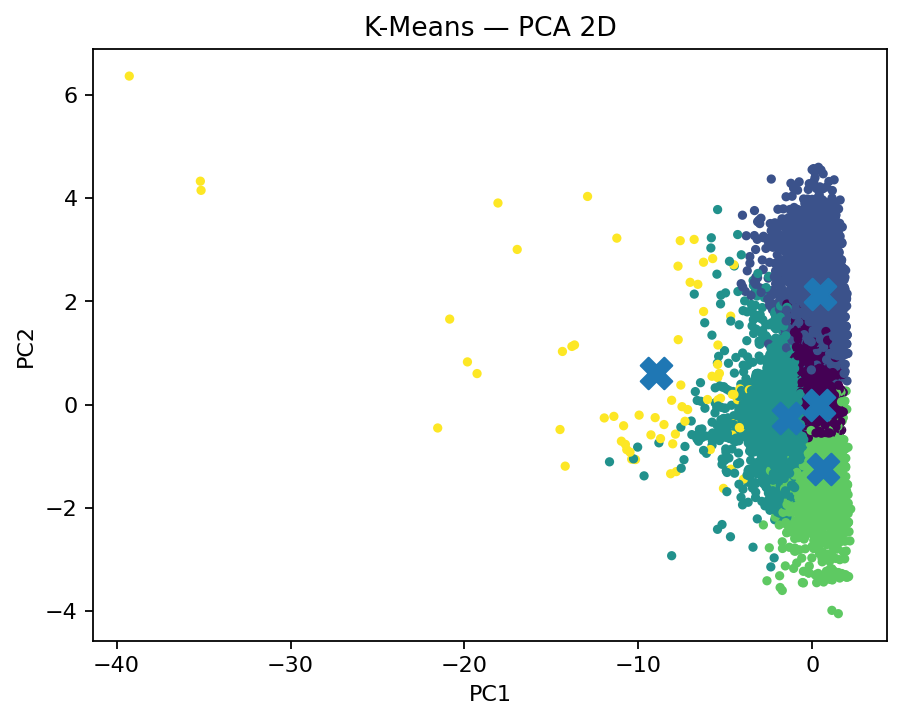

pred_path /content/model/kmeans_c2/predictions/
df salvo em /content/model/kmeans_c2/pca/data


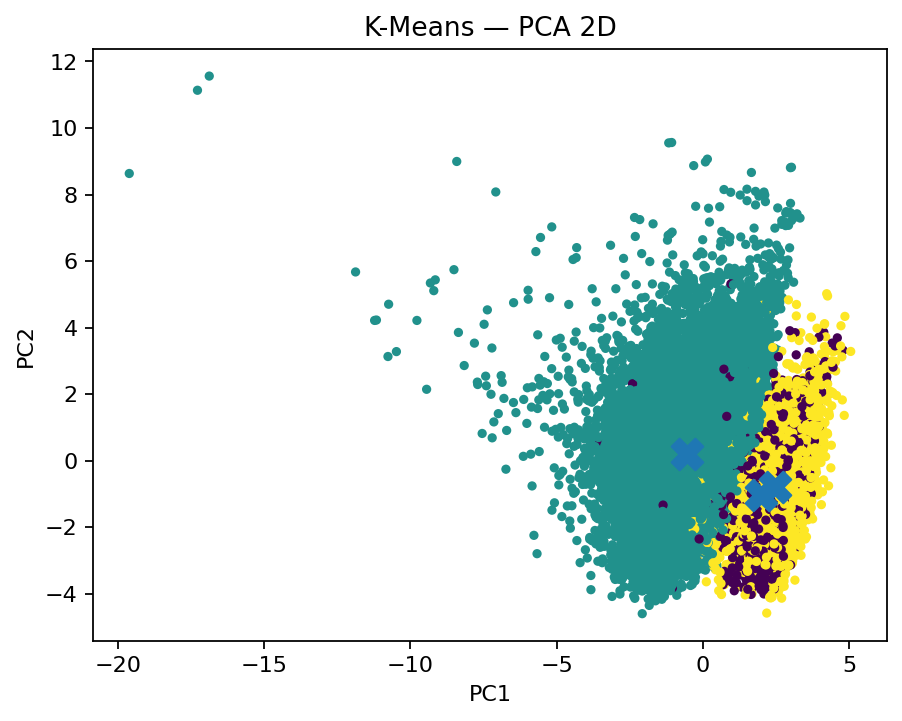

pred_path /content/model/kmeans_c3/predictions/
df salvo em /content/model/kmeans_c3/pca/data


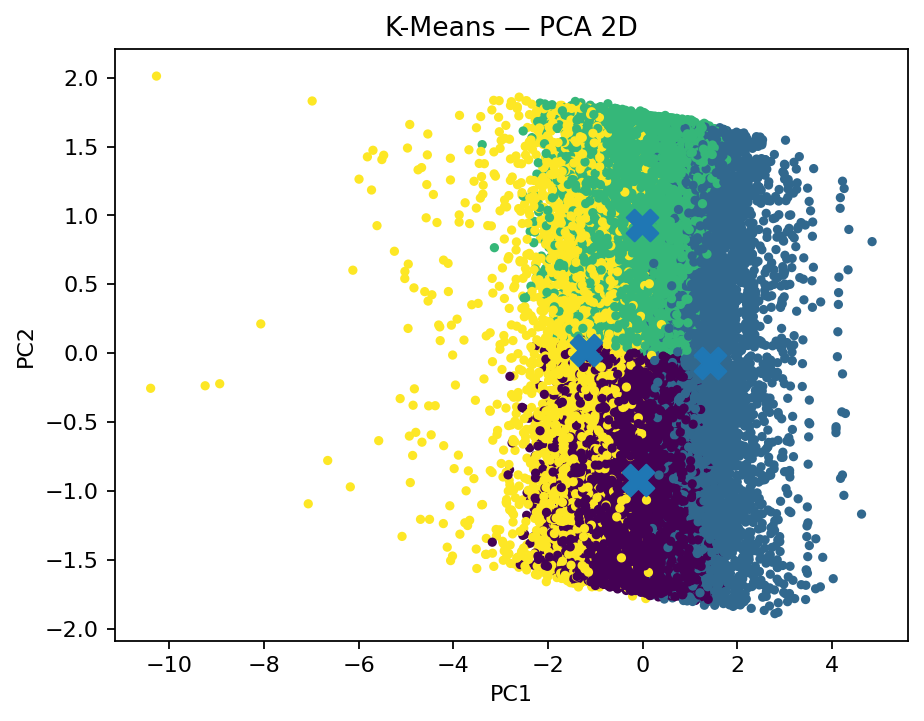

pred_path /content/model/kmeans_c1m/predictions/
df salvo em /content/model/kmeans_c1m/pca/data


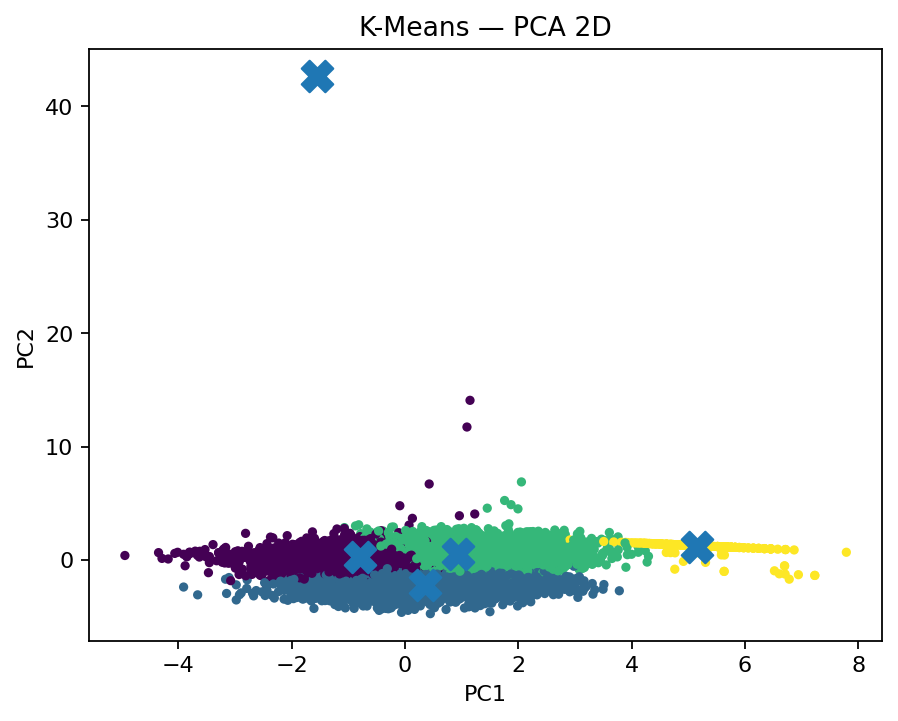

pred_path /content/model/kmeans_c3m/predictions/
df salvo em /content/model/kmeans_c3m/pca/data


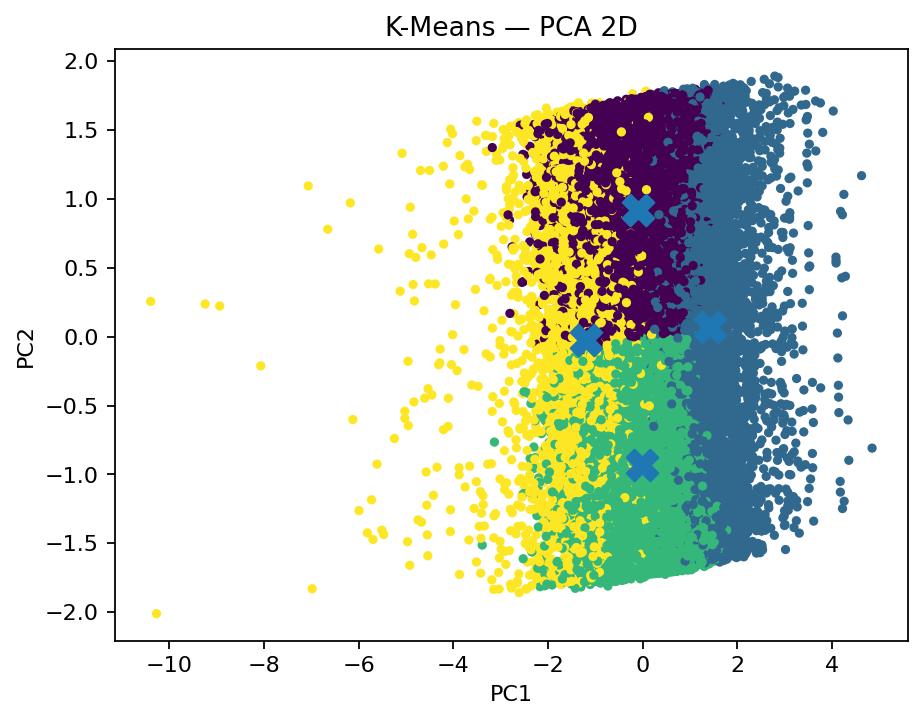

In [35]:
from IPython.display import display, Image
import os

# PCA 2D
for scen, conf in scenarios.items():
    try:
        pred_path = os.path.join(model_dir, f"kmeans_{scen}/predictions/")
        print("pred_path", pred_path)
        pred_df = spark.read.parquet(pred_path)

        # coluna de features (prioriza a escalada)
        candidate_cols = [f"features_{scen}_scaled", f"features_{scen}"]
        vec_col = next((c for c in candidate_cols if c in pred_df.columns), None)
        if vec_col is None:
            raise ValueError(f"Nenhuma coluna de features encontrada. Esperava {candidate_cols}")

        # diretórios
        pca_dir = os.path.join(model_dir, f"kmeans_{scen}", "pca")
        png_path = os.path.join(pca_dir, "plot.png")
        parquet_dir = os.path.join(pca_dir, "data")  # evita sobrescrever o PNG
        os.makedirs(pca_dir, exist_ok=True)

        # gera DF + PNG
        pca_df = run_pca_2d(pred_df, vec_col, plot=True, save_png_path=png_path)

        # salva DF em subpasta separada
        save_df(pca_df, parquet_dir)

        # exibe imagem se existir (caso contrário mostra inline)
        if os.path.exists(png_path):
            display(Image(filename=png_path))
        else:
            print(f"[PCA] aviso: PNG não encontrado em {png_path}; exibindo inline.")
            _ = run_pca_2d(pred_df, vec_col, plot=True, save_png_path=None)

    except Exception as e:
        print(f"[PCA] skip scen {scen}: {e}")


## Main - Fairness

In [36]:
# FAIRNESS — imprime e salva (um cenário por vez)
for scen, conf in scenarios.items():
    try:
        kmeans_path   = os.path.join(model_dir, f"kmeans_{scen}")
        pred_path     = os.path.join(kmeans_path, "predictions")
        fairness_path = os.path.join(kmeans_path, "fairness")

        # print("pred_path", pred_path)
        pred_df = spark.read.parquet(pred_path)

        print(f"kmeans_{scen}")
        rep = fairness_report(pred_df)

        # IMPRIME NO NOTEBOOK (ordenado e sem truncar)
        rep.orderBy("sensitive", "group", "prediction").show(50, truncate=False)

        # SALVA (usando a mesma assinatura 2-args do PCA: save_df(df, full_path))
        save_df(rep, fairness_path)

        # print("fairness_path", fairness_path)
        # print(f"[FAIRNESS] salvo em {fairness_path}")

    except Exception as e:
        print(f"[FAIRNESS] skip scen {scen}: {e}")


kmeans_c1
+----------+-----+-----+-------------------+---------+---------------------+-----------+--------------------+-------------+--------------------+--------------------+--------------------+
|prediction|group|count|share              |sensitive|global_share         |group_total|delta_pp            |cluster_count|cluster_prop        |nmi_cluster_age     |nmi_cluster_gender  |
+----------+-----+-----+-------------------+---------+---------------------+-----------+--------------------+-------------+--------------------+--------------------+--------------------+
|0         |25-34|9206 |0.15268011145017912|age      |0.06598337155963303  |19146      |1.5452473835500218  |120592       |0.8643348623853211  |0.016987227928814384|0.004317565636055512|
|1         |25-34|1135 |0.05781966377992868|age      |0.008135034403669725 |19146      |-7.940797383475023  |39260        |0.28139334862385323 |0.016987227928814384|0.004317565636055512|
|2         |25-34|5280 |0.16368032736065471|age      |0

In [37]:
def top_deltas(rep, n=5):
    return (rep.select("prediction","sensitive","group","delta_pp","cluster_prop")
              .withColumn("abs_delta", F.abs("delta_pp"))
              .orderBy(F.desc("abs_delta"))
              .limit(n))

for scen in ["c1","c2","c3"]:
    rep = spark.read.parquet(os.path.join(model_dir, f"kmeans_{scen}/fairness"))
    print(f"\n=== TOP Δ p.p. — {scen} ===")
    top_deltas(rep, 8).show(truncate=False)



=== TOP Δ p.p. — c1 ===
+----------+---------+-----+-------------------+--------------------+------------------+
|prediction|sensitive|group|delta_pp           |cluster_prop        |abs_delta         |
+----------+---------+-----+-------------------+--------------------+------------------+
|4         |age      |45-54|14.938016447781823 |0.005232224770642202|14.938016447781823|
|4         |gender   |f    |-12.874552281010432|0.005232224770642202|12.874552281010432|
|4         |gender   |m    |9.84053938356164   |0.005232224770642202|9.84053938356164  |
|2         |age      |65+  |-9.486556629363257 |0.46241399082568807 |9.486556629363257 |
|2         |age      |35-44|8.863662464996949  |0.46241399082568807 |8.863662464996949 |
|4         |age      |65+  |-8.26091609589041  |0.005232224770642202|8.26091609589041  |
|1         |age      |25-34|-7.940797383475023 |0.28139334862385323 |7.940797383475023 |
|1         |age      |55-64|7.414763798272631  |0.28139334862385323 |7.41476379827263

In [38]:
from pyspark.sql import functions as F
for scen, conf in scenarios.items():
    try:
        rep = spark.read.parquet(os.path.join(model_dir, f"kmeans_{scen}/fairness"))
        nmi = (rep
               .select(F.first("nmi_cluster_age").alias("nmi_age"),
                       F.first("nmi_cluster_gender").alias("nmi_gender"))
               .collect()[0])
        print(f"[NMI] {scen}: age={nmi['nmi_age']:.5f} | gender={nmi['nmi_gender']:.5f}")
    except Exception as e:
        print(f"[NMI] skip {scen}: {e}")


[NMI] c1: age=0.01699 | gender=0.00432
[NMI] c2: age=0.00819 | gender=0.00650
[NMI] c3: age=0.00778 | gender=0.00174
[NMI] c1m: age=0.02143 | gender=0.00396
[NMI] c3m: age=0.00778 | gender=0.00174


In [39]:
def fairness_summary(rep):
    """Resumo por atributo sensível: máximo e média dos deltas absolutos (p.p.)."""
    return (rep.groupBy("sensitive")
              .agg(F.max(F.abs("delta_pp")).alias("max_abs_delta_pp"),
                   F.avg(F.abs("delta_pp")).alias("mean_abs_delta_pp"))
             .orderBy("sensitive"))

def top_deltas_robusto(rep, n=8, min_cluster_prop=0.02):
    """Top Δ p.p., ignorando micro-clusters (padrão <2% do dataset)."""
    rep_f = rep.where(F.col("cluster_prop") >= F.lit(min_cluster_prop))
    return (rep_f.select("prediction","sensitive","group","delta_pp","cluster_prop")
                 .withColumn("abs_delta", F.abs("delta_pp"))
                 .orderBy(F.desc("abs_delta"))
                 .limit(n))




In [40]:
for scen, conf in scenarios.items():
    try:
        rep = spark.read.parquet(os.path.join(model_dir, f"kmeans_{scen}/fairness"))
        print(f"\n=== SUMMARY — {scen} ===")
        fairness_summary(rep).show(truncate=False)
        print(f"=== TOP Δ p.p. (robusto) — {scen} ===")
        top_deltas_robusto(rep, n=8, min_cluster_prop=0.02).show(truncate=False)
    except Exception as e:
        print(f"[SUMMARY] skip {scen}: {e}")


=== SUMMARY — c1 ===
+---------+------------------+------------------+
|sensitive|max_abs_delta_pp  |mean_abs_delta_pp |
+---------+------------------+------------------+
|age      |14.938016447781823|4.667192356771164 |
|gender   |12.874552281010432|3.7964366226327697|
+---------+------------------+------------------+

=== TOP Δ p.p. (robusto) — c1 ===
+----------+---------+-----+------------------+-------------------+-----------------+
|prediction|sensitive|group|delta_pp          |cluster_prop       |abs_delta        |
+----------+---------+-----+------------------+-------------------+-----------------+
|2         |age      |65+  |-9.486556629363257|0.46241399082568807|9.486556629363257|
|2         |age      |35-44|8.863662464996949 |0.46241399082568807|8.863662464996949|
|1         |age      |25-34|-7.940797383475023|0.28139334862385323|7.940797383475023|
|1         |age      |55-64|7.414763798272631 |0.28139334862385323|7.414763798272631|
|2         |gender   |na   |5.64809100231

In [41]:
def fairness_weighted(rep):
    # média ponderada por proporção do cluster
    return (rep.withColumn("w_abs_delta", F.abs("delta_pp")*F.col("cluster_prop"))
              .groupBy("sensitive")
              .agg(F.sum("w_abs_delta").alias("sum_w_abs_delta"),
                   F.avg(F.abs("delta_pp")).alias("mean_abs_delta_pp"),
                   F.max(F.abs("delta_pp")).alias("max_abs_delta_pp")))


In [42]:
def top_deltas_robusto(rep, n=8, min_prop=0.01):
    return (rep.filter(F.col("cluster_prop") >= min_prop)
              .select("prediction","sensitive","group","delta_pp","cluster_prop")
              .withColumn("abs_delta", F.abs("delta_pp"))
              .orderBy(F.desc("abs_delta"))
              .limit(n))


In [43]:
rows = []
for scen, conf in scenarios.items():
    rep = spark.read.parquet(os.path.join(model_dir, f"kmeans_{scen}/fairness"))
    # pega qualquer linha (NMI é constante por cenário no seu rep)
    nmi = rep.select("nmi_cluster_age","nmi_cluster_gender").limit(1).collect()[0]
    fw  = fairness_weighted(rep).toPandas().set_index("sensitive").to_dict("index")
    # pegue o best_k / silhouette que você já imprimiu (se salvou em algum lugar, ótimo; senão ignore)
    rows.append({
        "scenario": scen,
        "nmi_age": nmi["nmi_cluster_age"],
        "nmi_gender": nmi["nmi_cluster_gender"],
        "w_abs_delta_age": fw["age"]["sum_w_abs_delta"],
        "w_abs_delta_gender": fw["gender"]["sum_w_abs_delta"],
        "mean_abs_delta_age": fw["age"]["mean_abs_delta_pp"],
        "mean_abs_delta_gender": fw["gender"]["mean_abs_delta_pp"],
        "max_abs_delta_age": fw["age"]["max_abs_delta_pp"],
        "max_abs_delta_gender": fw["gender"]["max_abs_delta_pp"],
    })
summary_df = spark.createDataFrame(rows)
summary_df.show(truncate=False)


+------------------+--------------------+------------------+---------------------+--------------------+---------------------+--------+------------------+------------------+
|max_abs_delta_age |max_abs_delta_gender|mean_abs_delta_age|mean_abs_delta_gender|nmi_age             |nmi_gender           |scenario|w_abs_delta_age   |w_abs_delta_gender|
+------------------+--------------------+------------------+---------------------+--------------------+---------------------+--------+------------------+------------------+
|14.938016447781823|12.874552281010432  |4.667192356771164 |3.7964366226327697   |0.016987227928814384|0.004317565636055512 |c1      |33.515238106667155|15.401598731693463|
|18.41833284229698 |12.323847977110416  |3.3848729566100646|3.76290192872593     |0.008185632110671519|0.006499096230963423 |c2      |10.998732794877322|7.19237512723835  |
|9.187764393314072 |4.9688088066579095  |2.393496380309621 |1.4738607839905506   |0.007778938623688508|0.0017367240581426249|c3      |1

# Main -DBSCAN

In [44]:
for scen, conf in scenarios.items():
    try:
        pred_path = os.path.join(model_dir, f"kmeans_{scen}", "predictions")  # já contém 'prediction' e 'features_{scen}'
        pred_df   = spark.read.parquet(pred_path)

        # pega a coluna escalada; se não existir, cai para a crua
        cands = [f"features_{scen}_scaled", f"features_{scen}"]
        vec_col = next((c for c in cands if c in pred_df.columns), None)
        if vec_col is None:
            raise ValueError(f"Não achei coluna de features para {scen}. Tenho: {pred_df.columns}")
        print(f"[DBSCAN] usando coluna: {vec_col}")



        # DBSCAN em amostra (exploratório). Ajuste eps/min_samples se quiser.
        dbscan_df = run_dbscan_sample(
            pred_df,               # pode usar 'pred_df' para manter a coluna 'prediction' do KMeans
            vec_col,               # coluna vetorizada
            eps=0.7,               # típico se já padronizou com StandardScaler
            min_samples=10,
            sample_frac=0.2        # amostra para não estourar memória no driver
        )

        # Inspeção rápida (opcional)
        print(f"[DBSCAN] {scen} — distribuição de rótulos:")
        dbscan_df.groupBy("dbscan_label").count().orderBy("dbscan_label").show()

        # Salva saída (amostral) em /content/model/kmeans_{scen}/dbscan/
        save_df(dbscan_df, os.path.join(model_dir, f"kmeans_{scen}", "dbscan"))

    except Exception as e:
        print(f"[DBSCAN] skip {scen}: {e}")


[DBSCAN] usando coluna: features_c1_scaled
[DBSCAN] c1 — distribuição de rótulos:
+------------+-----+
|dbscan_label|count|
+------------+-----+
|          -1|  361|
|           0|27697|
+------------+-----+

df salvo em /content/model/kmeans_c1/dbscan
[DBSCAN] usando coluna: features_c2_scaled
[DBSCAN] c2 — distribuição de rótulos:
+------------+-----+
|dbscan_label|count|
+------------+-----+
|          -1|17845|
|           0| 1808|
|           1| 1896|
|           2|   63|
|           3| 1527|
|           4| 1376|
|           5| 1340|
|           6|  636|
|           7|  201|
|           8|   13|
|           9|   11|
|          10|   10|
|          11|   67|
|          12|   74|
|          13|  152|
|          14|   41|
|          15|   34|
|          16|   39|
|          17|   11|
|          18|  276|
+------------+-----+
only showing top 20 rows

df salvo em /content/model/kmeans_c2/dbscan
[DBSCAN] usando coluna: features_c3_scaled
[DBSCAN] c3 — distribuição de rótulos:
+--------

Visão geral (qualidade)

c1 (brutas) – k=2, sil=0.627: 2 segmentos bem separados; tamanhos 85% / 15%.

c2 (transf.+cat.) – k=2, sil=0.584 mas degenera p/ k≥3; cluster 0 tem só ~2,1% dos casos → cenário instável.

c3 (reduzidas) – k=4, sil=0.414; segmentos com limiares claros; tamanhos 28.5% / 30.8% / 18.8% / 21.9%.

Fairness (Δ p.p. = share_cluster − share_global)
c1 (k=2)

Idade (maiores desvios):

55–64 no cluster 1: +7.43 p.p.

45–54 no cluster 1: +5.88 p.p.

25–34 no cluster 1: −7.69 p.p.
→ Viés etário moderado (cluster 1 puxa mais 45–64; cluster 0 puxa 25–34).

Gênero: desvios pequenos

f: −2.57 p.p. (cl1), m: −1.53 p.p. (cl1), na: +4.10 p.p. (cl1).
→ Ok em gênero; atenção a gender=na no cluster 1.

c2 (k=2)

Cluster 0 = 2.1% dos registros. Deltas grandes (ex.: 65+ +13.07 p.p., 35–44 −11.48 p.p.) são efeito do tamanho minúsculo.
→ Não confiar em fairness deste cenário; manter como lição de FE (dimensão/colinearidade com OHE).

c3 (k=4)

Idade (pontos críticos):

35–44 no cluster 2: +8.82 p.p.

65+ no cluster 2: −9.84 p.p.

65+ no cluster 3: +4.51 p.p.

Gênero:

f no cluster 2: −4.59 p.p.

na no cluster 2: +4.84 p.p.

m: variações ≤ ~0.27 p.p.
→ Cluster 2 concentra 35–44 e gender=na; é o mais “carregado” em proxies.

Decisão prática p/ monografia

Baseline técnico: c1/k=2 (melhor separação; gênero ok; viés etário moderado e explicável).

Segmentação operacional: c3/k=4 (4 perfis úteis). Sinalizar que o cluster 2 tem sobre-representação de 35–44 e gender=na — tratar com cautela em políticas.

c2: documentar como anti-padrão (OHE + muitas derivadas ⇒ degradação e clusters degenerados).

Mitigações sugeridas (rápidas)

c1: reduzir correlação com idade

Usar debt_to_income (já tem no enrich) e/ou log em loan_amount e income.

Winsorizar extremos (ex.: p99) antes de padronizar.

c3:

“Gender missing” alto no cluster 2: criar flag gender_missing e separar regras/contatos para esse cluster; revisar origem de missing.

Se quiser reduzir Δ p.p. do cluster 2, remova uma derivada colinear (installment_proxy ou rate_per_month) e reavalie.

c2 (se insistir nele):

Diminuir dimensão: manter loan_amount, term, rate_of_interest, debt_to_income, credit_score, ltv + categorias principais; agrupar raras em “other”.